<a href="https://colab.research.google.com/github/Felix-kerich/Fraud-Detection-in-Electricity-and-Gas-Consumption/blob/master/Fraud_Detection_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook to get you started


This notebook covers:
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling
- Preprocessing the data and feature engineering
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [ ]:
DATA_DIR = '/content'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

## Download and extract files

In [ ]:
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
  if path.exists(pth) == False:
    os.mkdir(pth)

In [ ]:
#only run this cell once, at the start
import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [ ]:
!unzip "/content/train/train.zip" -d "/content/train/"


Archive:  /content/train/train.zip
  inflating: /content/train/client_train.csv  
  inflating: /content/train/invoice_train.csv  


In [ ]:
!unzip "/content/test/test.zip" -d "/content/test/"

Archive:  /content/test/test.zip
  inflating: /content/test/client_test.csv  
  inflating: /content/test/invoice_test.csv  


# Data Prep

## Import Libraries

In [ ]:
!pip install dask[dataframe]
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.4 MB/s eta 0:00:00


## Read the Data

In [ ]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False)

## Data Understanding

In [ ]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [ ]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [ ]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [ ]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [ ]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [ ]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [ ]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [ ]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [ ]:
#check for missing values
invoice_train.isnull().sum()

,0
client_id,0
invoice_date,0
tarif_type,0
counter_number,0
counter_statue,0
counter_code,0
reading_remarque,0
counter_coefficient,0
consommation_level_1,0
consommation_level_2,0


In [ ]:
#check for missing values
client_train.isnull().sum()

,0
disrict,0
client_id,0
client_catg,0
region,0
creation_date,0
target,0


No missing values in train set

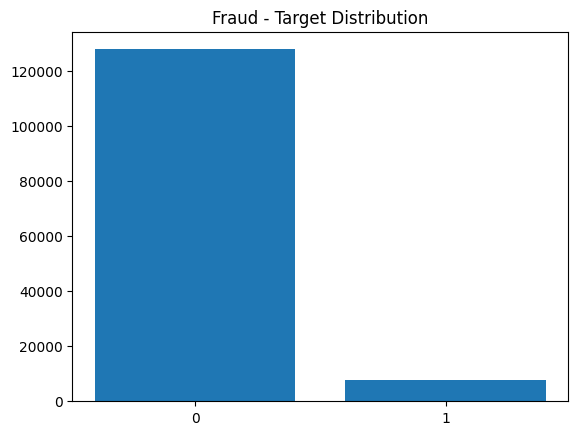

In [ ]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

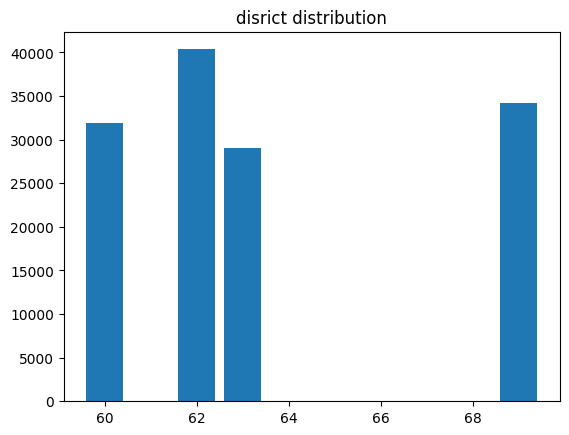

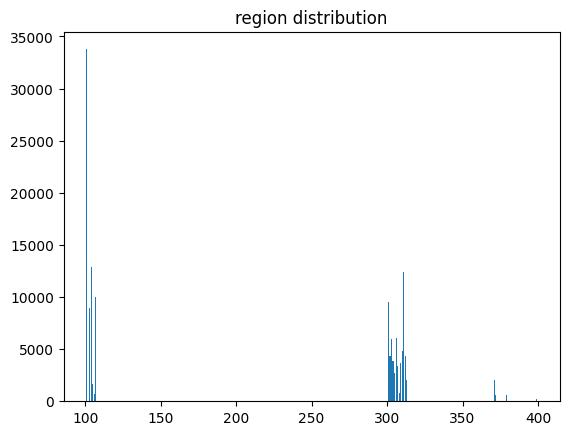

In [ ]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [ ]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [ ]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [ ]:
for df in [invoice_train, invoice_test]:
    df['invoice_age'] = (df['invoice_date'].max() - df['invoice_date']).dt.days


In [ ]:
def calculate_invoice_frequency(invoice_data):
    invoice_data['prev_invoice_date'] = invoice_data.groupby('client_id')['invoice_date'].shift(1)
    invoice_data['invoice_gap'] = (invoice_data['invoice_date'] - invoice_data['prev_invoice_date']).dt.days
    return invoice_data
invoice_train = calculate_invoice_frequency(invoice_train)
invoice_test = calculate_invoice_frequency(invoice_test)


In [ ]:
for df in [invoice_train, invoice_test]:
    df['total_consumption'] = (df['consommation_level_1'] +
                               df['consommation_level_2'] +
                               df['consommation_level_3'] +
                               df['consommation_level_4'])
    df['consumption_ratio_1'] = df['consommation_level_1'] / df['total_consumption']
    df['consumption_ratio_2'] = df['consommation_level_2'] / df['total_consumption']
    df['consumption_ratio_3'] = df['consommation_level_3'] / df['total_consumption']
    df['consumption_ratio_4'] = df['consommation_level_4'] / df['total_consumption']


In [ ]:
for df in [invoice_train, invoice_test]:
    df['consumption_delta'] = df['new_index'] - df['old_index']


In [ ]:
for df in [client_train, client_test]:
    df['creation_date'] = pd.to_datetime(df['creation_date'])

# Calculate account age
max_invoice_date = pd.to_datetime(invoice_train['invoice_date'].max())
for df in [client_train, client_test]:
    df['account_age'] = (max_invoice_date - df['creation_date']).dt.days

In [ ]:
def region_aggregates(client_data, invoice_data):
    return invoice_data.groupby(client_data['region']).agg({
        'total_consumption': ['mean', 'median'],
        'invoice_gap': ['mean', 'std']
    }).reset_index()


In [ ]:
for df in [invoice_train, invoice_test]:
    df['tariff_consumption_interaction'] = df['tarif_type'] * df['total_consumption']


In [ ]:
for df in [client_train, client_test]:
    df['region_catg_interaction'] = df['region'] * df['client_catg']


In [ ]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [ ]:
print(client_train.columns)


Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'region_catg_interaction', 'account_age'],
      dtype='object')


Train data

In [ ]:
def aggregate_invoice_data(invoice_data):
    aggs = {
        'consommation_level_1': ['mean'],
        'consommation_level_2': ['mean'],
        'consommation_level_3': ['mean'],
        'consommation_level_4': ['mean'],
        'total_consumption': ['mean', 'std'],
        'consumption_delta': ['mean', 'std'],
        'invoice_gap': ['mean', 'std'],
        'tariff_consumption_interaction': ['mean']
    }
    agg_data = invoice_data.groupby('client_id').agg(aggs)
    agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
    agg_data.reset_index(inplace=True)
    return agg_data
# Aggregate invoice_train
agg_invoice_train = aggregate_invoice_data(invoice_train)
selected_client_columns = ['client_id', 'region', 'client_catg', 'account_age', 'region_catg_interaction', 'target']
client_train_filtered = client_train[selected_client_columns]
# Merge client_train and aggregated invoice_train
merged_train = pd.merge(client_train_filtered, agg_invoice_train, on='client_id', how='left')
# Drop any unnecessary columns (if needed)
drop_columns = []  # Add columns to drop if required
merged_train.drop(columns=drop_columns, inplace=True, errors='ignore')

# Verify the merged dataset
print("Merged train shape:", merged_train.shape)
print("Merged train columns:", merged_train.columns)

Merged train shape: (135493, 17)
Merged train columns: Index(['client_id', 'region', 'client_catg', 'account_age',
       'region_catg_interaction', 'target', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean', 'total_consumption_mean',
       'total_consumption_std', 'consumption_delta_mean',
       'consumption_delta_std', 'invoice_gap_mean', 'invoice_gap_std',
       'tariff_consumption_interaction_mean'],
      dtype='object')


In [ ]:
print(merged_train.columns)


Index(['client_id', 'region', 'client_catg', 'account_age',
       'region_catg_interaction', 'target', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean', 'total_consumption_mean',
       'total_consumption_std', 'consumption_delta_mean',
       'consumption_delta_std', 'invoice_gap_mean', 'invoice_gap_std',
       'tariff_consumption_interaction_mean'],
      dtype='object')


Test data

In [ ]:
# Aggregate meaningful columns from invoice_test
agg_invoice_test = aggregate_invoice_data(invoice_test)

# Select meaningful columns from client_test
selected_client_columns = ['client_id', 'region', 'client_catg', 'account_age', 'region_catg_interaction']
client_test_filtered = client_test[selected_client_columns]

# Merge client_test and aggregated invoice_test
merged_test = pd.merge(client_test_filtered, agg_invoice_test, on='client_id', how='left')
test = merged_test
# Verify the test dataset structure
print("Merged test shape:", merged_test.shape)
print("Merged test columns:", merged_test.columns)

# Ensure columns match between train and test
train_columns = set(merged_train.columns) - {'target'}  # Exclude target from comparison
test_columns = set(merged_test.columns)
missing_columns_in_test = train_columns - test_columns

if missing_columns_in_test:
    print("Missing columns in test dataset:", missing_columns_in_test)
else:
    print("Test dataset columns match the train dataset!")


Merged test shape: (58069, 16)
Merged test columns: Index(['client_id', 'region', 'client_catg', 'account_age',
       'region_catg_interaction', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean', 'total_consumption_mean',
       'total_consumption_std', 'consumption_delta_mean',
       'consumption_delta_std', 'invoice_gap_mean', 'invoice_gap_std',
       'tariff_consumption_interaction_mean'],
      dtype='object')
Test dataset columns match the train dataset!


In [ ]:
X_train = merged_train.drop(columns=['target', 'client_id'], errors='ignore')  # Drop target and non-feature columns
y_train = merged_train['target']

In [ ]:
from sklearn.impute import SimpleImputer

# Define the imputer (mean strategy)
imputer = SimpleImputer(strategy='mean')

# Impute missing values in X_train
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Check if missing values are resolved
print("Missing values after imputation:")
print(X_train.isnull().sum())


Missing values after imputation:
region                                 0
client_catg                            0
account_age                            0
region_catg_interaction                0
consommation_level_1_mean              0
consommation_level_2_mean              0
consommation_level_3_mean              0
consommation_level_4_mean              0
total_consumption_mean                 0
total_consumption_std                  0
consumption_delta_mean                 0
consumption_delta_std                  0
invoice_gap_mean                       0
invoice_gap_std                        0
tariff_consumption_interaction_mean    0
dtype: int64


In [ ]:
# Check for missing values in X_train
print("Missing values in X_train:")
print(X_train.isnull().sum())

# Check percentage of missing values
missing_percentage = (X_train.isnull().sum() / len(X_train)) * 100
print("Percentage of missing values per column:")
print(missing_percentage)


Missing values in X_train:
region                                 0
client_catg                            0
account_age                            0
region_catg_interaction                0
consommation_level_1_mean              0
consommation_level_2_mean              0
consommation_level_3_mean              0
consommation_level_4_mean              0
total_consumption_mean                 0
total_consumption_std                  0
consumption_delta_mean                 0
consumption_delta_std                  0
invoice_gap_mean                       0
invoice_gap_std                        0
tariff_consumption_interaction_mean    0
dtype: int64
Percentage of missing values per column:
region                                 0.0
client_catg                            0.0
account_age                            0.0
region_catg_interaction                0.0
consommation_level_1_mean              0.0
consommation_level_2_mean              0.0
consommation_level_3_mean              0.0
con

Balancing Data

Original class distribution: Counter({0.0: 127927, 1.0: 7566})
New class distribution after SMOTE: Counter({0.0: 127927, 1.0: 127927})


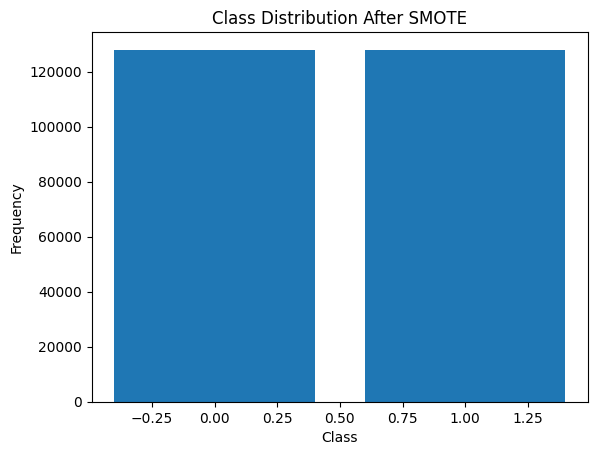

X_resampled shape: (255854, 15)
y_resampled shape: (255854,)


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt



# Print original class distribution
print("Original class distribution:", Counter(y_train))

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print new class distribution
print("New class distribution after SMOTE:", Counter(y_resampled))

# Optional: Visualize class distribution
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Verify the shape of the balanced data
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)


# Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Split the resampled dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
sub_client_id = test['client_id']
test_features = test.drop(columns=['client_id'], errors='ignore')
test_scaled = scaler.transform(test_features)
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # Input layer
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=6397, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the validation set
val_predictions = (model.predict(X_val) > 0.5).astype("int32")
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print("Classification Report:")
print(classification_report(y_val, val_predictions))


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5586 - loss: 0.6915 - val_accuracy: 0.6340 - val_loss: 0.6413
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6225 - loss: 0.6488 - val_accuracy: 0.6615 - val_loss: 0.6224
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6401 - loss: 0.6338 - val_accuracy: 0.6708 - val_loss: 0.6112
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6545 - loss: 0.6215 - val_accuracy: 0.6751 - val_loss: 0.6041
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6581 - loss: 0.6166 - val_accuracy: 0.6769 - val_loss: 0.5989
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6661 - loss: 0.6091 - val_accuracy: 0.6789 - val_loss: 0.5949
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6667 - loss: 0.6067 - val_accuracy: 0.6819 - val_loss: 0.5913
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6704 - loss: 0.6031 - val_accuracy: 0.6840 - v

In [ ]:
# Predict probabilities for the test set
test_predictions = model.predict(test_scaled)  # Ensure test data is scaled like training data

# Convert probabilities to binary predictions if needed
test_predictions = (test_predictions > 0.5).astype("int32")

# Create a DataFrame for predictions
submission = pd.DataFrame({
    'client_id': sub_client_id,  # Ensure this is the client ID from the test set
    'target': test_predictions.flatten()  # Flatten to avoid multi-dimensional issues
})

# Preview the submission file
print("Submission preview:")
print(submission.head())

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


1815/1815 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Submission preview:
          client_id  target
0     test_Client_0       0
1     test_Client_1       1
2    test_Client_10       1
3   test_Client_100       0
4  test_Client_1000       1
Submission file saved as 'submission.csv'


## Tips
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************